<a href="https://colab.research.google.com/github/HannanTechy/faster-taxi-tip/blob/main/Faster_Taxi_Tip_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 4.1 MB/s eta 0:00:00


In [7]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [8]:
# download June 2020 TLC Yellow Taxi Trip records
# !wget -nc https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv

--2023-07-08 07:52:34--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364904448 (348M) [text/csv]
Saving to: ‘yellow_tripdata_2019-06.csv.1’

yellow_tripdata_201 100%[===================>] 348.00M  13.1MB/s    in 21s     

2023-07-08 07:52:56 (16.7 MB/s) - ‘yellow_tripdata_2019-06.csv.1’ saved [364904448/364904448]



In [5]:
#from google.colab import files

#uploaded = files.upload()


Saving yellow_tripdata_2019-06.csv to yellow_tripdata_2019-06.csv


In [9]:
# read the input data
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display first rows in the dataset
raw_data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [10]:
#Reducing the data size to 100000 records
raw_data=raw_data.head(100000)

There are 65349 observations in the dataset.
There are 17 variables in the dataset.


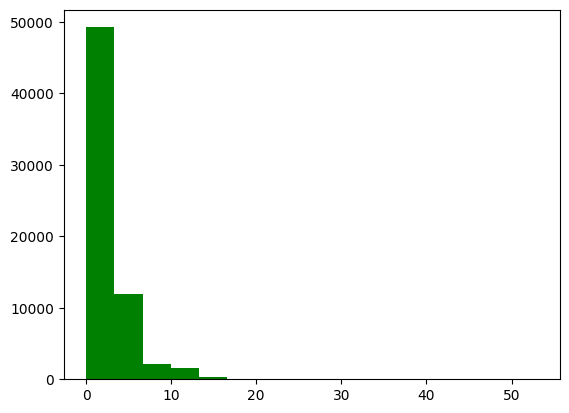

Minimum amount value is  0.01
Maximum amount value is  53.0
90% of the trips have a tip amount less or equal than  5.15


In [11]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
raw_data = raw_data[raw_data['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# we remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del raw_data
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

In [12]:
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

# ideally use the full dataset for this exercise
# however if you run into out of memory issues due to the data size, reduce it
# for instance, in this example we use only the first 1M samples
first_n_rows = 1000000
clean_data = clean_data.head(first_n_rows)

In [13]:
# drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_data
gc.collect()

4062

In [14]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (65349, 460) y.shape= (65349, 1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (45744, 460) Y_train.shape= (45744, 1)
X_test.shape= (19605, 460) Y_test.shape= (19605, 1)


In [16]:
# import the Decision Tree Regression Model from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  5.01789


In [17]:
# import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  2.03348


In [18]:

# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 2.47x 
[Scikit-Learn] MSE score : 1.615
[Snap ML] MSE score : 1.690
